# Saving, Loading Qiskit Machine Learning Models and Continuous Training

## Overview
This tutorial focuses on demonstrating how to save and load Qiskit machine learning models. It is of importance to know how to save a model, especially when a significant amount of time is invested in training a model on a real hardware. Next in line, we should know how to resume the training of "the previously saved model" after loading it. The approach shown in this tutorial can be used to train a model on a real hardware available on the cloud and then re-use the model for inference on a local simulator.

The model that we will save and then load to resume training is a `VQC` classifier that was introduced in [Neural Network Classifier & Regressor](https://qiskit.org/documentation/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html), to solve a binary classification problem.

## Introduction

In this tutorial we will cover how to:
* Generate a simple dataset
* Pre-process the dataset and visualize it by plotting
* Define, train and save a model
* Load the saved model and resume training
* Evaluate performance of models
* PyTorch hybrid models

First off, we fix a random seed for reproducibility purposes.

In [1]:
# Required import
from qiskit.utils import algorithm_globals

# Set seed of reproducibility
algorithm_globals.random_seed = 42

## 1. Prepare a dataset

We start by preparing a dataset. Here, we generate a small dataset in the same way as in other tutorials, with a slight difference from applying some transformations to the generated data. We generate `40` samples (or rows) of data, each sample having `2` features/attributes (or columns). The dataset has an input shape of `(40, 2)`. 

As this is a binary classification problem, the labels are obtained by summing up all columnar values for each row. If the sum is more than `1` then the sample is labeled as `1`, otherwise the sample is labeled as `0`.

We'll heavily use SciKit-Learn in this data preparation step

In [2]:
# Required import
import numpy as np

# Generate dataset
num_samples = 40  # Number of instances (or rows)
num_features = 2  # Number of features (or columns)
features = (
    2 * algorithm_globals.random.random([num_samples, num_features]) - 1
)  # Specifying the features
labels = 1 * (np.sum(features, axis=1) >= 0)  # Generating the labels in {0,1}

Further, we pre-process the data by scaling down or normalizing our features into a range of `[0, 1]` by using `MinMaxScaler` from SciKit-Learn. This is an important step as the Neural Networks work better on normalized data. While training, the model convergence is enhanced when this transformation is applied.

In [3]:
# Required import
from sklearn.preprocessing import MinMaxScaler

# Normalisation of dataset
print("Features of the first 5 samples before normalization: \n", features[0:5, :], end="\n\n")
features = MinMaxScaler().fit_transform(features)
print("Features of the first 5 samples after normalization: \n", features[0:5, :])

Features of the first 5 samples before normalization: 
 [[ 0.5479121  -0.12224312]
 [ 0.71719584  0.39473606]
 [-0.8116453   0.9512447 ]
 [ 0.5222794   0.57212861]
 [-0.74377273 -0.09922812]]

Features of the first 5 samples after normalization: 
 [[0.79067335 0.44566143]
 [0.88072937 0.7126244 ]
 [0.06741233 1.        ]
 [0.7770372  0.80422817]
 [0.10351936 0.45754615]]


## 2. Data Pre-processing

### 2.1 One Hot encode the labels
We select Variational Quantum Classifier (`VQC`) as a model of choice for classifying the dataset. This model takes one-hot encoded labels by default. So we must transform the labels in the set of `{0, 1}`, into one-hot representation. We employ SciKit-Learn for this transformation as well. 

Please note that the input array must be reshaped to `(num_samples, 1)` as a starting step. The `OneHotEncoder` encoder does not work with 1D arrays and our labels is a 1D array. To resolve this, one must decide the array to have only one feature (our case!) or have one sample. 

Also, by default the encoder returns sparse arrays, but for dataset plotting it is easier to have dense arrays, so we set `sparse` to `False`. 

In [4]:
# Reshape the labels
print("Input shape of labels before reshaping: ", labels.shape)
labels = labels.reshape(-1, 1)
print("Input shape of labels after reshaping:", labels.shape)

Input shape of labels before reshaping:  (40,)
Input shape of labels after reshaping: (40, 1)


Let's take a look at the labels of the first `5` labels of the dataset. The labels should be one-hot encoded.

In [5]:
# Required import
from sklearn.preprocessing import OneHotEncoder

# One Hot Encoding
print("The labels of the first 5 samples: \n", labels[0:5, :], end="\n\n")
labels = OneHotEncoder(sparse=False).fit_transform(labels)
print("The labels of the first 5 samples as one-hot encoded: \n", labels[0:5, :])

The labels of the first 5 samples: 
 [[1]
 [1]
 [1]
 [1]
 [0]]

The labels of the first 5 samples as one-hot encoded: 
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


### 2.2 Split the dataset into train and test
Now we split our dataset into two parts: training dataset and test dataset. As a rule of thumb, 80% of the original dataset should go into the training part and 20% into testing. Our original dataset has `40` samples so we give the training dataset `30` samples of the original dataset. The test dataset should be used only once to evaluate the model's performance on unseen data after it has been trained on the training dataset. 

We employ `train_test_split` from SciKit-Learn to split the data.

In [6]:
# Required import
from sklearn.model_selection import train_test_split

# Splitting of dataset
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=30, random_state=algorithm_globals.random_seed
)
train_features.shape

(30, 2)

### 2.3 Visualize the data

Now it is time to see how our dataset looks like. Let's plot it.

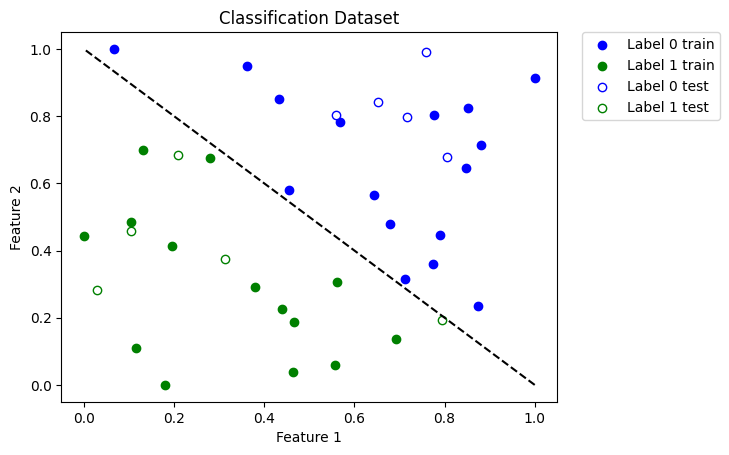

In [7]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt

# Reusable function to plot the dataset
def plot_dataset():
    # Class: Label 0 train
    plt.scatter(
        # x (index 0) coordinate of Label 0 in training samples
        train_features[np.where(train_labels[:, 0] == 0), 0],
        # y (index 1) coordinate of Label 0 in training samples
        train_features[np.where(train_labels[:, 0] == 0), 1],
        marker="o",
        color="b",
        label="Label 0 train",
    )

    # Class: Label 1 train
    plt.scatter(
        # x (index 0) coordinate of Label 1 in training samples
        train_features[np.where(train_labels[:, 0] == 1), 0],
        # y (index 1) coordinate of Label 1 in training samples
        train_features[np.where(train_labels[:, 0] == 1), 1],
        marker="o",
        color="g",
        label="Label 1 train",
    )

    # Class: Label 0 test
    plt.scatter(
        # x (index 0) coordinate of Label 0 in testing samples
        test_features[np.where(test_labels[:, 0] == 0), 0],
        # y (index 1) coordinate of Label 0 in testing samples
        test_features[np.where(test_labels[:, 0] == 0), 1],
        marker="o",
        facecolors="w",
        edgecolors="b",
        label="Label 0 test",
    )

    # Class: Label 1 test
    plt.scatter(
        # x (index 0) coordinate of Label 1 in testing samples
        test_features[np.where(test_labels[:, 0] == 1), 0],
        # y (index 1) coordinate of Label 1 in testing samples
        test_features[np.where(test_labels[:, 0] == 1), 1],
        marker="o",
        facecolors="w",
        edgecolors="g",
        label="Label 1 test",
    )

    # Specify Plot setttings
    plt.title("Classification Dataset")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.plot([1, 0], [0, 1], "--", color="black")


plot_dataset()
plt.show()

On the plot above we see:

* Solid <span style="color:blue">blue</span> dots are the samples from the training dataset labeled as `0`
* Empty <span style="color:blue">blue</span> dots are the samples from the test dataset labeled as `0`
* Solid <span style="color:green">green</span> dots are the samples from the training dataset labeled as `1`
* Empty <span style="color:green">green</span> dots are the samples from the test dataset labeled as `1`

We'll train our model using solid dots and verify it using empty dots.

## 3. Define, train and save a model

We'll train our model in two steps.
1. First, we train our model in `20` iterations using COBYLA optimizer and save the model
2. Second, we load the saved model and train it for `80` iterations using COBYLA optimizer

Let's start with the first step of training the original model.

In [8]:
maxiter = 20

Create an empty array for callback to store values of the objective function.

In [9]:
objective_values = []

We re-use a callback function from the [Neural Network Classifier & Regressor](https://qiskit.org/documentation/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html) tutorial to plot iteration versus objective function value with some minor tweaks to plot objective values at each iteration of training when fit() method is called on the model.

In [10]:
# Required import
from IPython.display import clear_output

# callback function that draws a live plot when the .fit() method is called on the model
def callback_graph(_, objective_value):
    clear_output(wait=True)
    objective_values.append(objective_value)

    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")

    stage1_len = np.min((len(objective_values), maxiter))
    stage1_x = np.linspace(1, stage1_len, stage1_len)
    stage1_y = objective_values[:stage1_len]

    stage2_len = np.max((0, len(objective_values) - maxiter))
    stage2_x = np.linspace(maxiter, maxiter + stage2_len - 1, stage2_len)
    stage2_y = objective_values[maxiter : maxiter + stage2_len]

    plt.plot(stage1_x, stage1_y, color="orange")
    plt.plot(stage2_x, stage2_y, color="purple")
    plt.show()


plt.rcParams["figure.figsize"] = (12, 6)

### 3.1 Define the model
As mentioned above we train a [VQC](https://qiskit.org/documentation/stable/0.24/tutorials/machine_learning/03_vqc.html) model and set [COBYLA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html) as an optimizer on an ansatz constructed using [RealAmplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html). Then we evaluate performance of the model to see how well it was trained. Followed by, saving this model as a file. Ultimately, we load this model to continue working with it.

Here, we manually construct an ansatz to fix an initial point to start the optimization from.

In [11]:
# Required imports
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.algorithms.classifiers import VQC

# Define the optimizer
original_optimizer = COBYLA(maxiter=maxiter)

# Construct the ansatz
ansatz = RealAmplitudes(num_features)

# Specify the initial point
initial_point = np.asarray([0.5] * ansatz.num_parameters)

We will be using two quantum simulators, in particular, two instances of the [Sampler](https://qiskit.org/documentation/stubs/qiskit.primitives.Sampler.html) primitive. We'll start training on the first instance of sampler and save the model. Then we will resume training of the loaded model on the second instance of sampler. 

In [12]:
# Required import
from qiskit.primitives import Sampler

# Sampler 1 for training the model
sampler1 = Sampler()

# Sampler 2 for resuming training of the loaded model
sampler2 = Sampler()

We create a model and set a sampler to the first sampler we created earlier.

In [13]:
# Required import
from qiskit_machine_learning.algorithms.classifiers import VQC

# Define the model
original_classifier = VQC(
    ansatz=ansatz,  # Real Amplitude ansatz of num_features
    optimizer=original_optimizer,  # COBYLA optimizer
    callback=callback_graph,  # callback function for live plotting on fitting the model
    sampler=sampler1,  # Sampler 1 for training the model
)

### 3.2 Train the model
Now it is time to train the model by fitting the model on the training dataset.

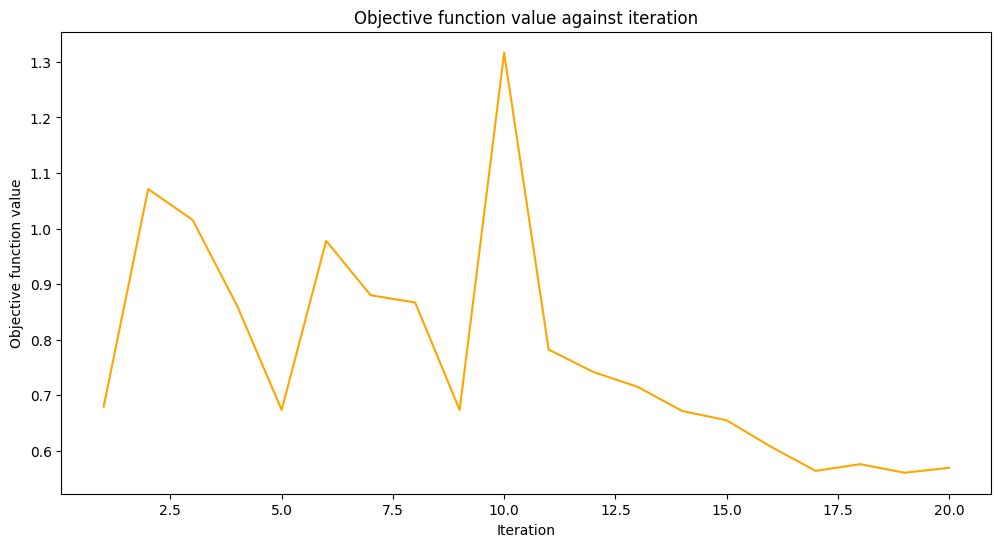

In [14]:
# Fit the model
original_classifier.fit(train_features, train_labels)

### 3.3 Evaluate the model
Let's see how well our model performs after the first step of training.

In [15]:
# Evaluate the model on training and testing data
original_classifier_train_score = original_classifier.score(train_features, train_labels)
original_classifier_test_score = original_classifier.score(test_features, test_labels)
print("Train score: ", original_classifier_train_score)
print("Test score: ", original_classifier_test_score)

Train score:  0.8333333333333334
Test score:  0.8


### 3.4 Save the model
Next, we save the model. You may choose any file name you want. Please note that the `save` method does not append an extension if it is not specified in the file name.

In [16]:
# Save the model
original_classifier.save("vqc_classifier.model")

## 4. Load the model and continue training
### 4.1 Load the model
To load the model, call the class method `load` of the model. In our case it is `VQC`. We pass the same file name we used in the previous section where we saved our model.

In [17]:
# Load the model
loaded_classifier = VQC.load("vqc_classifier.model")

### 4.2 Resume training of the model
Now, we want to alter the model in a way, such that it can be trained further on another simulator. To achieve this, we set the `warm_start` property to `True`. When `warm_start` is `True` and `fit()` is called, the model uses weights from previous fit to initiate the training of the loaded model. Here, we also set the `sampler` to the second instance of the `Sampler` primitive we created earlier. Finally, we create a new COBYLA optimizer with `maxiter` set to `80`, so the total number of iterations is `100` if we add 20 iterations done previously to the 80 iterations set now for the resumed training of the loaded model.

In [18]:
# Specify settings for resuming the Training process
loaded_classifier.warm_start = True
loaded_classifier.neural_network.sampler = sampler2
loaded_classifier.optimizer = COBYLA(maxiter=80)

Now we continue training our model from the state we finished in the previous section.

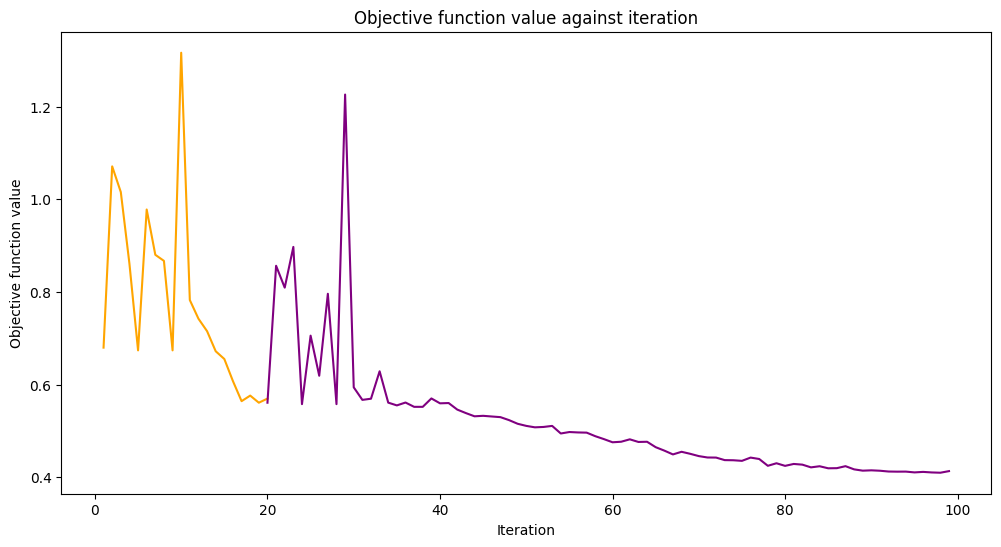

In [19]:
# Resume Training
loaded_classifier.fit(train_features, train_labels)

In [20]:
# Evaluate the model
loaded_classifier_train_score = loaded_classifier.score(train_features, train_labels)
loaded_classifier_test_score = loaded_classifier.score(test_features, test_labels)
print("Train score", loaded_classifier_train_score)
print("Test score", loaded_classifier_test_score)

Train score 0.8666666666666667
Test score 0.8


## 5. Evaluate the models
Let's see which data points were misclassified. First, we call `predict` to infer predicted values from the training and test features.

In [21]:
# Make predictions
train_predicts = loaded_classifier.predict(train_features)
test_predicts = loaded_classifier.predict(test_features)

Plot the whole dataset and the encircle the incorrectly classified points using red.

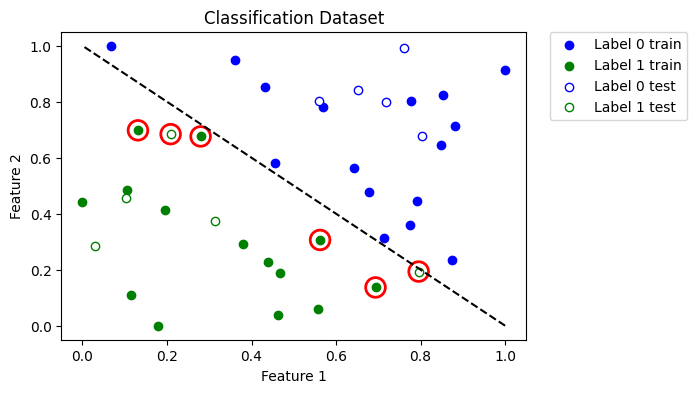

In [22]:
# return plot to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# Plot the dataset using thr function defined earlier
plot_dataset()

# Plot the misclassified data points
plt.scatter(
    # x coordinate (index 0) of datapoints where actual and predicted label don't match in training data
    train_features[np.all(train_labels != train_predicts, axis=1), 0],
    # y coordinate (index 1) of datapoints where actual and predicted label don't match in training data
    train_features[np.all(train_labels != train_predicts, axis=1), 1],
    s=200,
    facecolors="none",
    edgecolors="r",
    linewidths=2,
)
plt.scatter(
    # x coordinate (index 0) of datapoints where actual and predicted label don't match in testing data
    test_features[np.all(test_labels != test_predicts, axis=1), 0],
    # y coordinate (index 1) of datapoints where actual and predicted label don't match in testing data
    test_features[np.all(test_labels != test_predicts, axis=1), 1],
    s=200,
    facecolors="none",
    edgecolors="r",
    linewidths=2,
)

In [23]:
# Evaluate the score of the models
print(f"Model               | Test Score | Train Score")
print(f"-----------------------------------------------")
print(
    f"Original VQC Model  | {original_classifier_train_score:10.2f} | {original_classifier_test_score:10.2f}"
)
print(f"-----------------------------------------------")
print(
    f"Loaded VQC Model    | {loaded_classifier_train_score:10.2f} | {loaded_classifier_test_score:10.2f}"
)

Model               | Test Score | Train Score
-----------------------------------------------
Original VQC Model  |       0.83 |       0.80
-----------------------------------------------
Loaded VQC Model    |       0.87 |       0.80


Clearly the loaded model performs better on training data due to more training iterations on a pre-trained model. 

## 6. PyTorch hybrid models

To save and load hybrid models, when using the TorchConnector, follow the PyTorch recommendations of saving and loading the models. For more details please refer to the [PyTorch Connector tutorial](https://qiskit.org/documentation/machine-learning/tutorials/05_torch_connector.html) where a short snippet shows how to do it.

Take a look at this pseudo-like code to get the idea:
```python
# create a QNN and a hybrid model
qnn = create_qnn()
model = Net(qnn)
# ... train the model ...

# save the model
torch.save(model.state_dict(), "model.pt")

# create a new model
new_qnn = create_qnn()
loaded_model = Net(new_qnn)
loaded_model.load_state_dict(torch.load("model.pt"))
```

## What was learned

Congratulations! Now if you have a large dataset or a large model you can train it in multiple steps as shown in this tutorial, summarized as follows:
* Generate a simple dataset
* Pre-process and visualize the dataset
* Define, train and save a model
* Load the saved model and resume training
* Evaluate performance of models
* PyTorch hybrid models

In [24]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright